# step 0: setup

### conda environment:
1. make new environment:
    code:
    conda create -n lab-week2 python=3 snpeff=4.3 freebayes vcflib vcftools bwa samtools
    
2. activate new environment:
    code:
    conda activate lab-week2
    
3. when done, to return to old environment:
    code:
    conda deactivate

### data
1. sequencing data: ten sets of single-end Illumina sequencing reads, each for a different yeast strain
    
    code:
    
    wget "http://67.207.142.119/outgoing/BYxRM_subset.tar.xv"
    
    tar -xvzf BYxRM_subset.tar.xv
    
2. reference data Saccharomyces cerevisiae reference genome. This reference is called sacCer3 by the UCSC genome browser, but its name in the NCBI Assembly archive is R64-1-1. combine these files into a single whole-genome reference

    code:
    
    wget "http://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/chromFa.tar.gz"

    tar -xvzf chromFa.tar.gz

    cat chr*.fa > sacCer3.fa

    rm chr*.fa

### directory setup
cd ~/qbb2020-answers/week2

mkdir files

# Step 1: Index the sacCer3 genome with bwa index

bwa index -a bwtsw sacCer3.fa

flag explination:
    
    -a STR    BWT construction algorithm: bwtsw, best for long genomes (is yeast 'long'?)

output:
    
    sacCer3.fa
    
    sacCer3.fa.amb
    
    sacCer3.fa.ann
    
    sacCer3.fa.bwt
    
    sacCer3.fa.pac
    
    sacCer3.fa.sa
    
similar to the suffix index we were talking about in lecture

# Step 2: Alignment with bwa mem

saved as a bash script called "steptwo.sh":

#!/bin/bash

for SAMPLE in 09 11 23 24 27 31 35 39 62 63

do

    bwa mem -R "@RG\tID:${SAMPLE}\tSM:${SAMPLE}" -o ~/qbb2020-answers/week2/files/${SAMPLE}.sam ~/qbb2020-answers/week2/files/sacCer3.fa ~/qbb2020-answers/week2/files/A01_${SAMPLE}.fastq 
    
done


then in the command line:

chmod u+x steptwo.sh

./steptwo.sh

# Step 3: Create a sorted bam file with samtools, for input to variant callers

#!/bin/bash

for SAMPLE in 09 11 23 24 27 31 35 39 62 63
do
    samtools sort -o ~/qbb2020-answers/week2/files/${SAMPLE}.bam -O bam ~/qbb2020-answers/week2/files/${SAMPLE}.sam
    done

then in the command line:

chmod u+x step3.sh

./step3.sh

# Step 4: Variant calling with freebayes


freebayes -f sacCer3.fa --genotype-qualities -p 1 ??.bam > yeast.vcf

-f:
     Use FILE as the reference sequence for analysis. An index file (FILE.fai) will be created if none exists. If neither --targets nor --region are specified, FreeBayeswill analyze every position in this reference.
     
     
--genotype-qualities:
    Calculate the marginal probability of genotypes and report as GQ in each sample field in the VCF output.
    
    
-p:
    ploidy--our is haploid?

# Step 5: Filter variants based on genotype quality using vcffilter

vcffilter -f "QUAL > 20" yeast.vcf > results.vcf
Filter your VCF so that you only keep variants whose estimated probability of being polymorphic is greater than 0.99. You should consider how to do this with the -f flag. The freebayes documentation will be helpful here, as well as this vcffilter info.

# Step 6: Decompose complex haplotypes using vcfallelicprimitives

vcfallelicprimitives -k -g results.vcf > primitives.vcf

We suggest using the -k and -g flags to keep annotations for the variant sites and sample genotypes in your VCF.
-k  Maintain site and allele-level annotations when decomposing. Note that in many cases, such as multisample VCFs, these won't be valid post-decomposition.  For biallelic loci in single-sample VCFs, they should be usable with caution.
-g Maintain genotype-level annotations when decomposing.  Similar caution should be used for this as for --keep-info.
You can reference vcfallelicprimitives documentation 1 and vcfallelicprimitives documentation 2.

# Step 7: Variant effect prediction with snpeff ann

First, fetch the appropriate yeast reference database:
snpeff download R64-1-1.86
snpeff ann -download R64-1-1.86 -csvStats stats.txt primitives.vcf > snpeffoutput.vcf
Then, use snpeff ann to annotate your VCF with the predicted functional effects that these genetic variants may have.

We recommend not Googling the snpeff documenation. It will tell you to use java -jar snpEff.jar, which you should not. The help option for snpeff ann’s command-line tool is 100 times better.

# Step 8: Exploratory data analysis through plotting

In Python, produce a nicely formatted and labeled multi-panel plot describing your variants.

Explore each of the following characteristics of the variant genotypes called across all ten yeast samples. (Each characteristic will be a subplot in the multi-panel plot).

The read depth distribution of variant genotypes (histogram)
This information can be found in the sample specific FORMAT field for each variant/line. Check the file header to decide which ID is appropriate.
The quality distribution of variant genotypes (histogram)
This information can be found in the sample specific FORMAT field for each variant/line. Check the file header to decide which ID is appropriate.
The allele frequency spectrum of your identified variants (histogram)
This information is pre-calculated for you and can be found in the variant specific INFO field. Check the file header to decide which ID is appropriate.
A summary of the predicted effect(s) of each variant as determed by snpEff (barplot)
This information was added to the VCF by snpEff and can be found in the variant specific INFO field. Check the file header to decide which ID is appropriate and how to parse the information.
We encourage you to consider every possible effect for each variant, but feel free to just grab the first one.
You may find it helpful to reference this page of the snpeff manual, which describes the format of its output VCF.

ok so some psedocode:
    first we have to load in the file
    then we have to parse it, looking for:
        read depth
        quality distribution
        allele frequency
        snpEff
        

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:

#vcf = open('/Users/cmdb/qbb2020-answers/week2/files/snpeffoutput.vcf', 'r')
vcf = open('/Users/cmdb/qbb2020-answers/week2/files/annotated1000.vcf', 'r')
#
DF_list = []
GQ_list = []
AF_list = []
PE_list = []
GQ_list2 = []
count = 0

for line in vcf:

    if line.startswith('#'):
        continue
    fields = line.strip('\r\n').split('\t')
    #fields[0] = chr, fields[1] = pos, fields[2]=ID, fields[3]=ref, fields[4] = alt, feilds[5]= QUAL, fields[6]= filter, fields[7]= info1, fields[8]=formatdescrip, fields[9]= format
    
    fields = line.strip('\r\n').split('\t')
    
    info_subfields = fields[7].split(';')
    format_subfields = fields[9].split(':')
    
    DF_list.append(format_subfields[2])
    GQ_list.append(format_subfields[1])
    AF_temp = info_subfields[3]
    AF_temp2 = AF_temp[3:]
    AF_list.append(AF_temp2)
    
    #PE_list.append(info_subfields[])

print(DF_list[:10])
vcf.close()
    #DF

['21', '21', '38', '9', '13', '20', '32', '29', '23', '3']


Text(0.5, 0, 'Allele Frequncy')

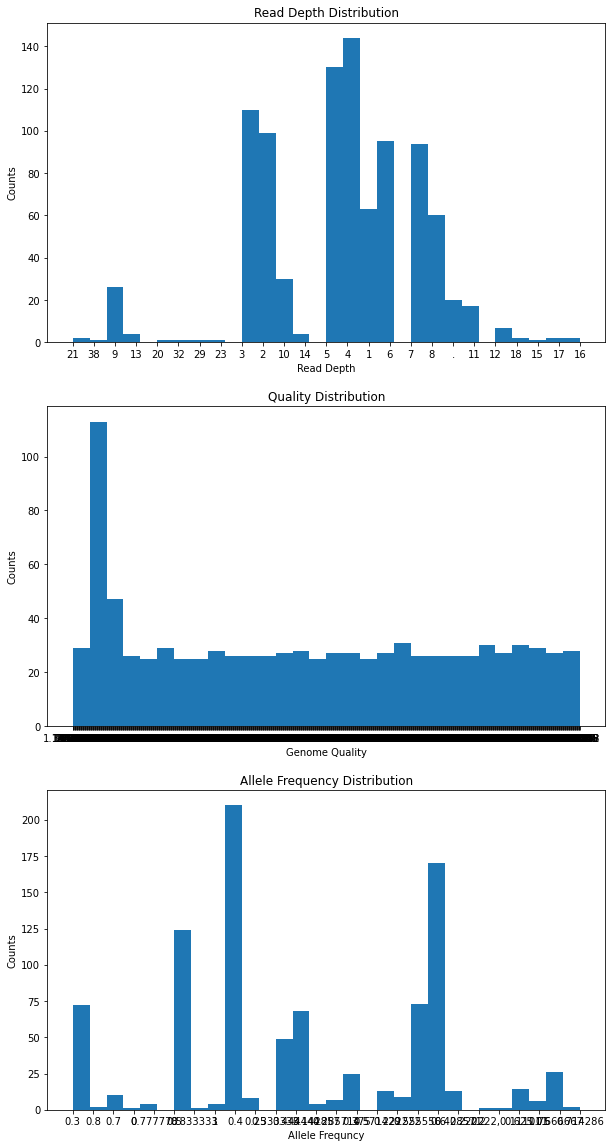

In [24]:
fig, ax = plt.subplots( nrows = 3)
fig.set_figheight(20)
fig.set_figwidth(10)
ax[0].hist((DF_list), bins = 30)
#come back and figure out how to fix the scale
ax[0].set_title('Read Depth Distribution')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Read Depth')

ax[1].hist((GQ_list), bins = 30)
ax[1].set_title('Quality Distribution')
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('Genome Quality')

ax[2].hist((AF_list), bins = 30)
ax[2].set_title('Allele Frequency Distribution')
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('Allele Frequncy')
# for the 4th plot I realized that the snpEff variable was not actually loaded into my new VCF. I will have to re-run that step in order to fix it. 

#ax[1].hist(GQ_list, bins = 30)
#ax[0].set_xlim(0,300)
#ax[1].hist((GQ_list), bins = 30)
#ax[2].hist(allele_freq, bins = 15)

ax.hist(df_k27.loc[:,'width'])
fig, ax = plt.subplots( 1,3 )
ax[0].bar( coi2, chr_k4.loc[ coi2 ] )
ax[0].set_xlabel("Location")
ax[0].set_ylabel("Number of Hits")
ax[0].set_title("Lys 4")
ax[0].set_ylim(0, 950)
ax[1].bar( coi2, chr_k9.loc[ coi2 ] )
ax[1].set_xlabel("Location")
ax[1].set_ylabel("Number of Hits")
ax[1].set_title("Lys 9")
ax[1].set_ylim(0, 950)
ax[2].bar( coi2, chr_k27.loc[ coi2 ] )
ax[2].set_xlabel("Location")
ax[2].set_ylabel("Number of Hits")
ax[2].set_title("Lys 27")
ax[2].set_ylim(0, 950)
fig.tight_layout()
#plt.xlabel('Location')
#plt.ylabel('Number of Hits')
#plt.suptitle('K4')

#ax[1].plot( x2, y2 )
#
#ax[0].set_ylim(0.0,200.0)
#pltpy.show()

# submit

Push all scripts, a record of your command line commands (if applicable), your multi-panel plot, and ONLY the first 1000 lines of your filtered, decomposed, and annotated VCF to your qbb2020-answers repo. Do not push any other raw data to Github, and do not push the full VCF!

vcf = open('/Users/cmdb/qbb2020-answers/week2/files/snpeffoutput.vcf', 'r')
vcf.close()